In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# New Section

In [2]:
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.io import loadmat


In [34]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
import numpy as np
import tensorflow as tf
import time
tf.set_random_seed(1)
np.random.seed(1)
num_epochs=200
display_step=1
var=1
mean=0
beta=0.0 # This is the L2-Regularization parameter
mini_batch_size=3*10**3  # Number of examples for training
num_batches = 4*10**2
m_test=10**4   # Number of examples for testing
num_test_batch = 10

In [60]:
eta = 1
P_b = 10 #Watt or 40 dBm
P_i = 0 #Watt or 40 dBm
sigma_n = np.sqrt(3.98*10**-14)
M = 8    #Power Beam
N = 16   #of IRS elements

In [74]:
alpha = 2.57
alpha_irs = 2.2;
Lc = 10**-3;

d_br = 20;
d_rs = 15;
d_sb = 25;
d_is = 15;
d_id = 30
d_rd = 15;
d_sd = 25;
d_ir = 15;

b_bs = Lc*d_sb**(-alpha);
b_is = Lc*d_is**(-alpha);
b_id = Lc*d_id**(-alpha);
b_sd = Lc*d_sd**(-alpha_irs);
b_rs = Lc*d_rs**(-alpha_irs);
b_rd = Lc*d_rd**(-alpha_irs);
b_ir = Lc*d_ir**(-alpha_irs);
b_br = Lc*d_br**(-alpha_irs);

np.random.seed(11)
h_bs = (np.random.randn(num_batches, M,mini_batch_size)+1j*np.random.randn(num_batches, M,mini_batch_size))*np.sqrt(b_bs/2)
h_is = (np.random.randn(num_batches, 1,mini_batch_size)+1j*np.random.randn(num_batches, 1,mini_batch_size))*np.sqrt(b_is/2)
h_id = (np.random.randn(num_batches, 1,mini_batch_size)+1j*np.random.randn(num_batches, 1,mini_batch_size))*np.sqrt(b_id/2)
h_sd = (np.random.randn(num_batches, 1,mini_batch_size)+1j*np.random.randn(num_batches, 1,mini_batch_size))*np.sqrt(b_sd/2)
g_rs = (np.random.randn(num_batches, N,mini_batch_size)+1j*np.random.randn(num_batches, N,mini_batch_size))*np.sqrt(b_rs/2)
#g_sr = np.random.randn(num_batches, N,mini_batch_size)+1j*np.random.randn(num_batches, N,mini_batch_size)
g_rd = (np.random.randn(num_batches, N,mini_batch_size)+1j*np.random.randn(num_batches, N,mini_batch_size))*np.sqrt(b_rd/2)
g_ir = (np.random.randn(num_batches, N,mini_batch_size)+1j*np.random.randn(num_batches, N,mini_batch_size))*np.sqrt(b_ir/2)
G_br = (np.random.randn(num_batches, N,M*mini_batch_size)+1j*np.random.randn(num_batches, N,M*mini_batch_size))*np.sqrt(b_br/2)
 
print("Shape of h_bs  is: "+str(h_bs.shape))
print("Shape of h_is  is: "+str(h_is.shape))
print("Shape of h_id  is: "+str(h_id.shape))
print("Shape of h_sd  is: "+str(h_sd.shape))
print("Shape of g_rs  is: "+str(g_rs.shape))
print("Shape of g_rd  is: "+str(g_rd.shape))
print("Shape of g_ir  is: "+str(g_ir.shape))
print("Shape of G_br  is: "+str(G_br.shape))
 
np.random.seed(144)
h_bs_t = (np.random.randn( M,mini_batch_size)+1j*np.random.randn( M,mini_batch_size))*np.sqrt(b_bs/2)
h_is_t = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_is/2)
h_id_t = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_id/2)
h_sd_t = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_sd/2)
g_rs_t = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rs/2)
g_rd_t = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rd/2)
g_ir_t = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_ir/2)
G_br_t = (np.random.randn( N,M*mini_batch_size)+1j*np.random.randn( N,M*mini_batch_size))*np.sqrt(b_br/2)

Shape of h_bs  is: (400, 8, 1000)
Shape of h_is  is: (400, 1, 1000)
Shape of h_id  is: (400, 1, 1000)
Shape of h_sd  is: (400, 1, 1000)
Shape of g_rs  is: (400, 16, 1000)
Shape of g_rd  is: (400, 16, 1000)
Shape of g_ir  is: (400, 16, 1000)
Shape of G_br  is: (400, 16, 8000)


In [62]:
dims = [2*(N*M+M+N+1),5*(N*M+M+N+1), 6*(N*M+M+N+1), 5*(N*M+M+N+1),4*(N*M+M+N+1),1*(N*M+M+N+1), 2*N+2]
seed = np.random.randint(400)
#seed = 12
print(seed)
tf.reset_default_graph()
W1=tf.get_variable("W1",[dims[1],dims[0]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b1=tf.get_variable("b1",[dims[1],1],dtype="float64", initializer = tf.zeros_initializer())
W2=tf.get_variable("W2",[dims[2],dims[1]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b2=tf.get_variable("b2",[dims[2],1],dtype="float64", initializer = tf.zeros_initializer())
W3=tf.get_variable("W3",[dims[3],dims[2]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b3=tf.get_variable("b3",[dims[3],1],dtype="float64", initializer = tf.zeros_initializer())
W4=tf.get_variable("W4",[dims[4],dims[3]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b4=tf.get_variable("b4",[dims[4],1],dtype="float64", initializer = tf.zeros_initializer())
W5=tf.get_variable("W5",[dims[5],dims[4]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b5=tf.get_variable("b5",[dims[5],1],dtype="float64", initializer = tf.zeros_initializer())
W6=tf.get_variable("W6",[dims[6],dims[5]],dtype="float64", initializer = tf.contrib.layers.xavier_initializer(seed = seed))
b6=tf.get_variable("b6",[dims[6],1],dtype="float64", initializer = tf.zeros_initializer())
#tau = tf.get_variable("tau",[1,1],dtype="float64", initializer = tf.zeros_initializer())
 
X = tf.placeholder(tf.float64, shape=(2*(N*M+M+N+1),None))

382


In [63]:
Z1 = tf.add(tf.matmul(W1,X),b1)                     # Linear Layer
mean, variance = tf.nn.moments(Z1, axes= [1] ,keepdims=True)
Z1_BN = tf.nn.batch_normalization(Z1, mean=mean, variance= variance, scale=1.0, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
A1 = tf.nn.dropout(tf.nn.relu(Z1_BN),rate = 0.0, seed= 95)        # Relu Layer
 
Z2 = tf.add(tf.matmul(W2,A1),b2)                     # Linear Layer
mean, variance = tf.nn.moments(Z2, axes= [1] ,keepdims=True)
Z2_BN = tf.nn.batch_normalization(Z2, mean=mean, variance= variance, scale=1.0, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
A2 = tf.nn.dropout(tf.nn.relu(Z2),rate = 0.0, seed= 195) 
 
 
Z3 = tf.add(tf.matmul(W3,A2),b3)                     # Linear Layer
mean, variance = tf.nn.moments(Z3, axes= [1] ,keepdims=True)
Z3_BN = tf.nn.batch_normalization(Z3, mean=mean, variance= variance, scale=1, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
A3 = tf.nn.relu(Z3)

Z4 = tf.add(tf.matmul(W4,A3),b4)                     # Linear Layer
mean, variance = tf.nn.moments(Z4, axes= [1],keepdims=True)
Z4_BN = tf.nn.batch_normalization(Z4, mean=mean, variance= variance, scale=1, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
A4 = tf.nn.relu(Z4) 


Z5 = tf.add(tf.matmul(W5,A4),b5)                     # Linear Layer
mean, variance = tf.nn.moments(Z5, axes= [1],keepdims=True)
Z5_BN = tf.nn.batch_normalization(Z5, mean=mean, variance= variance, scale=1, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
A5 = tf.nn.leaky_relu(Z5_BN,0.) 
theta1 = tf.nn.sigmoid(Z5)
Z6 = tf.add(tf.matmul(W6,A5),b6)                     # Linear Layer
# mean, variance = tf.nn.moments(Z6, axes= [1],keepdims=True)
# Z6_BN = tf.nn.batch_normalization(Z6, mean=mean, variance= variance/variance, scale=1, offset= None, variance_epsilon=10**-5) # Batch Normalization Layer
theta1 = tf.nn.sigmoid(Z6)

## The cost function is,


In [64]:
real = tf.zeros([N,tf.shape(X)[1]],dtype=tf.float64)
#tau = tf.constant(0.1,dtype= tf.float64)
log_base = tf.constant(2,dtype=tf.float64)
etta = 1 

In [65]:
theta_et1, theta_it1,tau,lemda = tf.split(theta1, num_or_size_splits= [N,N,1,1], axis = 0)
theta_et = tf.exp(tf.complex(real,theta_et1*2*np.pi))
theta_it = tf.exp(tf.complex(real,theta_it1*2*np.pi))
# theta_et =loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/theta_et.mat')['theta_et']
# print(theta_et.shape)  
# theta_it = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/theta_it.mat')['theta_it']
# print(theta_it.shape) 

g_theta_et1 = tf.reshape(tf.complex(X[0:N*M,:],X[N*M:2*N*M,:]),[N,M*tf.shape(X)[1]])

g_theta_et2 = g_theta_et1*tf.repeat(theta_et,M,axis=1)

#g_theta_et6 = tf.reduce_sum(tf.transpose(g_theta_et2),axis = 1, keepdims=True)

g_theta_et = tf.transpose(tf.reshape((tf.reduce_sum(g_theta_et2,axis = 0, keepdims= True)),[tf.shape(X)[1],M]),perm=[1,0])

h_bs_c = tf.complex(X[2*N*M:2*N*M+M,:],X[2*N*M+M:2*N*M+2*M,:])


Es = etta*tau*P_b*(tf.real(tf.norm((h_bs_c+g_theta_et), axis=0))**2)

P_s = etta*(tau/(1-tau))*P_b*(tf.real(tf.norm((h_bs_c+g_theta_et), axis=0))**2)


g_theta_it1 = tf.complex(X[2*N*M+2*M:2*N*M+2*M+N,:],X[2*N*M+2*M+N:2*N*M+2*M+2*N,:])
g_theta_it = tf.reduce_sum(g_theta_it1*theta_it,axis = 0)
h_sd_c = tf.complex(X[2*N*M+2*M+2*N:2*N*M+2*M+2*N+1,:],X[2*N*M+2*M+2*N+1:2*N*M+2*M+2*N+2,:])
rd = P_s*(tf.abs((h_sd_c+g_theta_it)**2))/((sigma_n)**2)
r = (1-tau)*tf.log(1+rd)/tf.log(log_base)
cost = -tf.reduce_mean(r)*10
cost1 = cost+lemda*tf.norm(theta1)

In [ ]:

# g_rs = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/g_rs.mat')['g_rs']
# G_br = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/G_br.mat')['G_br']
# h_bs = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/h_bs.mat')['h_bs']
# g_rd = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/g_rd.mat')['g_rd']
# h_sd = loadmat('/content/drive/MyDrive/DL_prejects/Cost_varification_data/h_sd.mat')['h_sd']

# # j =0
# mini_batch_size = 3;
# g_rs1 =  np.repeat(g_rs,M,axis = 1)
# F = np.reshape(G_br*g_rs1, [N*M,mini_batch_size])
# F = np.concatenate([np.real(F),np.imag(F)],axis=0)
# F1 = np.concatenate([np.real(h_bs),np.imag(h_bs)],axis=0)
# F2 = g_rd*g_rs
# F2 = np.concatenate([np.real(F2),np.imag(F2)],axis=0)
# F3 = np.concatenate([np.real(h_sd),np.imag(h_sd)],axis=0)
# F = np.concatenate([F,F1,F2,F3],axis=0)
# F.shape
# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)
# print(sess.run(r,feed_dict={X:F}))


In [67]:
decay = 0.5

In [68]:
lr = 0.001
step_rate =500*10**2


global_step = tf.Variable(0, trainable=False)
increment_global_step = tf.assign(global_step, global_step + 1)
learning_rate = tf.train.exponential_decay(lr, global_step, step_rate, decay, staircase=True)

  
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate )
minimize_loss = optimizer.minimize(cost, global_step = global_step)

In [69]:
init = tf.global_variables_initializer()

In [70]:
sess = tf.Session()
sess.run(init)
num_epochs = 500

In [79]:
cost_train_plt = []
cost_test_plt = []
start_time=time.time()
for epoch in range(num_epochs):
  epoch1 = epoch
  #np.random.shuffle(h_train)
  for j in range(num_batches):
    g_rs1 =  np.repeat(g_rs[j],M,axis = 1)
    F = np.reshape(G_br[j]*g_rs1, [N*M,mini_batch_size])
    F = np.concatenate([np.real(F),np.imag(F)],axis=0)
    F1 = np.concatenate([np.real(h_bs[j]),np.imag(h_bs[j])],axis=0)
    F2 = g_rd[j]*g_rs[j]
    F2 = np.concatenate([np.real(F2),np.imag(F2)],axis=0)
    F3 = np.concatenate([np.real(h_sd[j]),np.imag(h_sd[j])],axis=0)
    F = np.concatenate([F,F1,F2,F3],axis=0)
    sess.run(minimize_loss,feed_dict={X:F})
    #print(sess.run(cost, feed_dict={X:h_train[j]}))
  if (epoch) % display_step == 0:
      print('Learning Rate',sess.run(optimizer._lr))
      #print('Sum_Rate:',sess.run(sum_R, feed_dict={X:h_train[j]}))
      c = sess.run(cost, feed_dict={X:F})
      cost_train_plt.append(np.reshape(c,[1]))

      g_rs1 =  np.repeat(g_rs_t,M,axis = 1)
      F = np.reshape(G_br_t*g_rs1, [N*M,mini_batch_size])
      F = np.concatenate([np.real(F),np.imag(F)],axis=0)
      F1 = np.concatenate([np.real(h_bs_t),np.imag(h_bs_t)],axis=0)
      F2 = g_rd_t*g_rs_t
      F2 = np.concatenate([np.real(F2),np.imag(F2)],axis=0)
      F3 = np.concatenate([np.real(h_sd_t),np.imag(h_sd_t)],axis=0)
      F_test = np.concatenate([F,F1,F2,F3],axis=0)
      
      cost_test=sess.run(cost, feed_dict={X:F_test}) 
      cost_test_plt.append(np.reshape(cost_test,[1]))
      print("Epoch: " +str(epoch) + " Training Loss= "+ str(c) + " Validation Loss= "+ str(cost_test) )
      #print(sess.run(P,feed_dict={X:h_train[j]}))
duration = time.time()-start_time        
print("The duration for training is: "+str(duration)) 
print("The cost for test data is: " + str(cost_test))
plt.subplot(223)
plt.plot(cost_train_plt ,label= 'training Loss')
plt.plot(cost_test_plt, label= 'test loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
print("Optimization Finished!")

Learning Rate 0.00025
Epoch: 0 Training Loss= -47.98722878749386 Validation Loss= -48.51397456986789
Learning Rate 0.00025
Epoch: 1 Training Loss= -47.987628618841285 Validation Loss= -48.51988204100283
Learning Rate 0.00025
Epoch: 2 Training Loss= -47.98689126144386 Validation Loss= -48.5202353679135
Learning Rate 0.00025
Epoch: 3 Training Loss= -47.987491566386296 Validation Loss= -48.517189914883936
Learning Rate 0.00025
Epoch: 4 Training Loss= -47.988546585512694 Validation Loss= -48.511664383736914
Learning Rate 0.00025
Epoch: 5 Training Loss= -47.985640974021706 Validation Loss= -48.511261010608806
Learning Rate 0.00025
Epoch: 6 Training Loss= -47.98834648021021 Validation Loss= -48.51237880570168
Learning Rate 0.00025
Epoch: 7 Training Loss= -47.98695054595232 Validation Loss= -48.513229820189174
Learning Rate 0.00025
Epoch: 8 Training Loss= -47.98525466684968 Validation Loss= -48.51345621132525
Learning Rate 0.00025
Epoch: 9 Training Loss= -47.98583846324179 Validation Loss= -4

KeyboardInterrupt: ignored

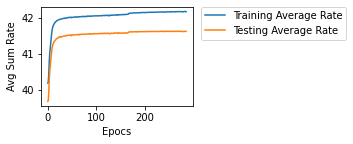

In [25]:
a = -np.array(cost_train_plt)
b = -np.array(cost_test_plt)
plt.subplot(223)
plt.plot(a ,label= 'Training Average Rate')
plt.plot(b, label= 'Testing Average Rate')
plt.xlabel('Epocs')
plt.ylabel('Avg Sum Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad = 0.)
plt.show()
# graph_folder = '/content/drive/MyDrive/DL_prejects/Graph_data'
# savemat(graph_folder+'/M8_tau_learned_train_rate.mat',{'Train_rate': a})
# savemat(graph_folder+'/M8_tau_learned_Valid_rate.mat',{'Valid_rate': b})

## Save Trained Parameters

In [83]:
trained_param_folder = '/content/drive/MyDrive/Trainedweights'
Save_train_param = True 
if Save_train_param== True:
  savemat(trained_param_folder+'/W1.mat',{'W1': sess.run(W1)})
  savemat(trained_param_folder+'/W2.mat',{'W2': sess.run(W2)})
  savemat(trained_param_folder+'/W3.mat',{'W3': sess.run(W3)})
  savemat(trained_param_folder+'/W4.mat',{'W4': sess.run(W4)})
  savemat(trained_param_folder+'/W5.mat',{'W5': sess.run(W5)})
  savemat(trained_param_folder+'/W6.mat',{'W6': sess.run(W6)})

  savemat(trained_param_folder+'/b1.mat',{'b1': sess.run(b1)})
  savemat(trained_param_folder+'/b2.mat',{'b2': sess.run(b2)})
  savemat(trained_param_folder+'/b3.mat',{'b3': sess.run(b3)})
  savemat(trained_param_folder+'/b4.mat',{'b4': sess.run(b4)})
  savemat(trained_param_folder+'/b5.mat',{'b5': sess.run(b5)})
  savemat(trained_param_folder+'/b6.mat',{'b6': sess.run(b6)})

In [ ]:
str(M)

'4'

## Load Trained Parameters

In [80]:
mini_batch_size = 10**3
np.random.seed(112)

h_bs_test = (np.random.randn( M,mini_batch_size)+1j*np.random.randn( M,mini_batch_size))*np.sqrt(b_bs/2)
h_is_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_is/2)
h_id_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_id/2)
h_sd_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_sd/2)
g_rs_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rs/2)
g_sr_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rd/2)
g_rd_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rd/2)
g_ir_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_ir/2)
G_br_test = (np.random.randn( N,M*mini_batch_size)+1j*np.random.randn( N,M*mini_batch_size))*np.sqrt(b_br/2)

tic = time.time()
g_rs1 =  np.repeat(g_rs_test,M,axis = 1)
F = np.reshape(G_br_test*g_rs1, [N*M,mini_batch_size])
F = np.concatenate([np.real(F),np.imag(F)],axis=0)
F1 = np.concatenate([np.real(h_bs_test),np.imag(h_bs_test)],axis=0)
F2 = g_rd_test*g_rs_test
F2 = np.concatenate([np.real(F2),np.imag(F2)],axis=0)
F3 = np.concatenate([np.real(h_sd_test),np.imag(h_sd_test)],axis=0)
F = np.concatenate([F,F1,F2,F3],axis=0)

Cost = sess.run(cost, feed_dict={X:F})
toc = time.time() 
print(toc-tic)
print(Cost)
Cost = sess.run(tau, feed_dict={X:F})
np.mean(Cost)

0.019833087921142578
-48.88455342152605


0.23550943418712386

In [ ]:
mini_batch_size = 10**0

t = np.zeros((1000,1))
for i in range(1000):
    mini_batch_size = 10**0
    h_bs_test = (np.random.randn( M,mini_batch_size)+1j*np.random.randn( M,mini_batch_size))*np.sqrt(b_bs/2)
    h_is_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_is/2)
    h_id_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_id/2)
    h_sd_test = (np.random.randn( 1,mini_batch_size)+1j*np.random.randn( 1,mini_batch_size))*np.sqrt(b_sd/2)
    g_rs_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rs/2)
    g_sr_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rd/2)
    g_rd_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_rd/2)
    g_ir_test = (np.random.randn( N,mini_batch_size)+1j*np.random.randn( N,mini_batch_size))*np.sqrt(b_ir/2)
    G_br_test = (np.random.randn( N,M*mini_batch_size)+1j*np.random.randn( N,M*mini_batch_size))*np.sqrt(b_br/2)
    
    tic = time.time()
    g_rs1 =  np.repeat(g_rs_test,M,axis = 1)
    F = np.reshape(G_br_test*g_rs1, [N*M,mini_batch_size])
    F = np.concatenate([np.real(F),np.imag(F)],axis=0)
    F1 = np.concatenate([np.real(h_bs_test),np.imag(h_bs_test)],axis=0)
    F2 = g_rd_test*g_rs_test
    F2 = np.concatenate([np.real(F2),np.imag(F2)],axis=0)
    F3 = np.concatenate([np.real(h_sd_test),np.imag(h_sd_test)],axis=0)
    F = np.concatenate([F,F1,F2,F3],axis=0)

    Cost = sess.run(cost, feed_dict={X:F})
    toc = time.time() 
    t[i] = toc-tic
print(np.mean(t))
print(Cost)
Cost = sess.run(tau, feed_dict={X:F})
np.mean(Cost)

0.0020459666252136233
-0.757640044401787


0.5700643924910194